In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
class write():    
    def printExamples(self):
        grouped = self.df.groupby(['organization name', 'website'])
        for (org_name, website), group_data in grouped:
            print("***************************")
            print(f"Organization: {org_name}, Website: {website}")
            for col in ['generated_description', 'Tasks/Jobs', 'Industry', 'Customers', 'generated_description_conf_interval', 'parsed_description_conf_interval']:
                print(f"{col}: {group_data.iloc[0][col]}")
            for example, example_data in group_data.groupby('example'):
                print("_________________________")
                print(f"Example: {example}")
                for col in ['situation_conf_interval', 'situation_conf_interval_reasoning']:
                    print(f"{col}: {example_data.iloc[0][col]}")
                for idx, row in example_data.iterrows():
                    print("##########################")
                    for col in ['job', 'onet_title', 'onet_task', 'example_job_title', 'task_similarity', 'job_title_similarity', 'onet_weight']:
                        print(f"{col}: {row[col]}")
            print("***************************\n")
        
        def writeExamples(self):
            output_file_path = "../output/examples.txt"
            with open(output_file_path, 'w') as f:
                grouped = self.df.groupby(['organization name', 'website'])
                for (org_name, website), group_data in grouped:
                    f.write("***************************\n")
                    f.write(f"Organization: {org_name}, Website: {website}\n")
                    for col in ['generated_description', 'Tasks/Jobs', 'Industry', 'Customers', 'generated_description_conf_interval', 'parsed_description_conf_interval']:
                        f.write(f"{col}: {group_data.iloc[0][col]}\n")
                    for example, example_data in group_data.groupby('example'):
                        f.write("_________________________\n")
                        f.write(f"Example: {example}\n")
                        for col in ['situation_conf_interval', 'situation_conf_interval_reasoning']:
                            f.write(f"{col}: {example_data.iloc[0][col]}\n")
                        for idx, row in example_data.iterrows():
                            f.write("##########################\n")
                            for col in ['job', 'onet_title', 'onet_task', 'example_job_title', 'task_similarity', 'job_title_similarity','onet_weight']:
                                f.write(f"{col}: {row[col]}\n")
                    f.write("***************************\n\n")
                        
        def generateOutput(self):
            self.conf_interval_text = self.conf_interval if self.conf_interval != True else 'all'
            output_file_path = f"../output/output_{self.task_sim}_{self.title_sim}_{self.conf_interval_text}.txt"
            
            with open(output_file_path, 'w') as f:
                
                group_sums = self.df.groupby('Minor Group Name')['onet_weight'].sum().sort_values(ascending=False)
                f.write(f"{self.num_onet_startups} Startups Founded post launch of chatGPT with 1-10 employees\n")
                
                f.write(f"Task Similarity: {self.task_sim}, Title Similarity {self.title_sim}, Confidence Interval: {self.conf_interval_text}\n")
                f.write(f"{self.num_onet_startups} startups out of {self.num_startups} decomposed\n")
                f.write("Decomposition of startup effect on labor market\n")
                
                for group_name in group_sums.index:
                    group_data = self.df[self.df['Minor Group Name'] == group_name]
                    f.write("*****************\n")
                    f.write(f"Group: {group_name}\n")
                    onet_titles = group_data.groupby('onet_title')['onet_weight'].sum().round(2).sort_values(ascending=False).reset_index()
                    onet_tasks = group_data.groupby('onet_task')['onet_weight'].sum().round(2).sort_values(ascending=False).reset_index()
                    
                    f.write("________________\n")
                    f.write("10 Most Highly Weighted Titles:\n")
                    for index, row in onet_titles.iterrows():
                        f.write(f"Title: {row['onet_title']}, Weight: {row['onet_weight']}\n")
                    f.write("\n")
                
                    f.write("10 Most Highly Weighted Tasks:\n")
                    for index, row in list(onet_tasks.iterrows())[:10]:
                        f.write(f"Task: {row['onet_task']}, Weight: {row['onet_weight']}\n")
                    f.write("\n")
                
                    f.write("10 Example Startups:\n")
                    startups = group_data.groupby(['organization_name','website'])['onet_weight'].sum().round(2).sort_values(ascending=False).reset_index()
                    for index, row in list(startups.iterrows())[:10]:
                        f.write(f"Startup: {row['organization_name']}, Website: {row['website']}\n")
                    f.write("\n")
        


In [147]:
class output():
    def __init__(self):
        self.codes = pd.read_csv("../input/soc_codes/soc_codes.csv",index_col=0)
        print(self.codes.columns)

    
    def getONET(self,task_sim, title_sim, conf_interval=True):
        self.task_sim = task_sim
        self.title_sim = title_sim
        self.conf_interval = conf_interval
        self.onet_df = pd.read_csv("../output/results v2/onet_df.csv")
        self.onet_df = self.onet_df[(self.onet_df.task_similarity > task_sim) & (self.onet_df.job_title_similarity > title_sim)].reset_index(drop=True)
        self.onet_df = self.onet_df[self.onet_df.situation_conf_interval > conf_interval]
        self.computeONETWeights()
        self.getStartupData()
        
        print(f"{len(self.onet_df)} tasks with task similarity > {task_sim} and title similarity > {title_sim}")
        self.num_onet_startups = len(self.df["organization name"].unique())
        self.num_startups = len(self.startup_df["organization name"].unique())
        print(f"{self.num_onet_startups} startups out of {self.num_startups} decomposed")
        
    def computeONETWeights(self):
        self.onet_weights = self.onet_df.groupby("organization_name")["onet_title"].count().apply(lambda x: 1/x).reset_index().rename({"onet_title":"onet_weight"},axis=1)
        self.onet_df = self.onet_df.merge(self.onet_weights, on="organization_name")

    def getONETTitles(self):
        self.onet_titles = self.df.groupby("onet_title").aggregate({"onet_weight":"sum","Detailed Occupation":"first"})
        self.onet_titles.onet_weight = self.onet_titles.onet_weight.round(2)
        self.onet_titles = self.onet_titles.reset_index().sort_values(by="onet_weight", ascending=False) 
        return self.onet_titles

    def getStartupGeneratedLLMTitles(self):
        self.example_job_titles_df = onet_df.example_job_title.value_counts().apply(lambda x: x/3).reset_index()
        return self.example_job_titles_df

    def printTop100ONETTasks(self):
        self.top_100_ONETtasks = onet_df['onet_task'].value_counts().reset_index().head(100)
        self.top_100_tasks.columns = ['Task', 'Frequency']
        for index, row in self.top_100_tasks.iterrows():
            print(f"Task = {row['Task']}, Frequency = {row['Frequency']}\n")
    
    def getStartupData(self):
        self.startup_df = pd.read_csv("../output/results v2/df_with_examples.csv")
        cols = ['organization name', 'founded date','website','description_all', 'industries_parsed', 'generated_description', 'parsed_description', 'Tasks/Jobs', 'Industry', 'Customers','generated_description_conf_interval','parsed_description_conf_interval']
        self.df = self.startup_df[cols]
        self.df = self.df.merge(self.onet_df,left_on="organization name",right_on="organization_name")
        self.df = self.df.merge(self.codes,left_on="onet_title",right_on="Title")

    def getWage(self):
        self.wage_employment = pd.read_csv("../input/wage_employment/wage_employment_bls.csv")
        self.wage_employment = self.wage_employment[self.wage_employment.O_GROUP == "detailed"]
    
        
    def getSkills(self):
        self.skills_df = pd.read_csv("../input/skills/Skills.csv")
        self.skills_df = self.skills_df[self.skills_df["Scale Name"]=="Importance"]
        self.skills_df = self.skills_df.rename(columns={"O*NET-SOC Code":"Detailed Occupation"})
        self.skills_df["Detailed Occupation"] = self.skills_df["Detailed Occupation"].replace(r'\.\d{2}', '', regex=True)
        self.skills_df = self.skills_df.pivot_table(index=self.skills_df["Detailed Occupation"], columns='Element Name', values='Data Value', fill_value=0)

    def BLS(self):
        self.titles_df = self.getONETTitles()
        onet_titles_df = self.titles_df.merge(self.wage_employment, left_on="Detailed Occupation", right_on="OCC_CODE")
        self.wages_df = onet_titles_df.merge(self.codes, on="Detailed Occupation", how="outer")
        self.wages_df = self.wages_df.replace("#",np.nan).replace("*",np.nan).replace({",":""}, regex=True)
        self.wages_df[["H_MEDIAN","A_MEDIAN"]] = self.wages_df[["H_MEDIAN","A_MEDIAN"]].astype("float")
        plt.figure(figsize=(14, 6))
        for major_group_name in self.wages_df['Major Group Name'].unique():
            subset = self.wages_df[self.wages_df['Major Group Name'] == major_group_name]
            plt.scatter(subset['onet_weight'], subset['H_MEDIAN'], label=major_group_name)
        plt.xlabel('ONET Weight')
        plt.ylabel('Hourly Median Wage')
        plt.title('Hourly Median Wage vs. ONET Weight')
        plt.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize='small')
        plt.tight_layout()
        plt.show()
    
        # Scatter plot for A_MEDIAN (Annual Median Wage)
        plt.figure(figsize=(14, 6))
        for major_group_name in self.wages_df['Major Group Name'].unique():
            subset = self.wages_df[self.wages_df['Major Group Name'] == major_group_name]
            plt.scatter(subset['onet_weight'], subset['A_MEDIAN'], label=major_group_name)
        plt.xlabel('ONET Weight')
        plt.ylabel('Annual Median Wage')
        plt.title('Annual Median Wage vs. ONET Weight')
        plt.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize='small')
        plt.tight_layout()
        plt.show()


   

Index(['Major Group', 'Minor Group', 'Broad Group', 'Detailed Occupation',
       'Title', 'Major Group Name', 'Minor Group Name', 'Broad Group Name'],
      dtype='object')
2023 tasks with task similarity > 0.67 and title similarity > 0.7
518 startups out of 990 decomposed


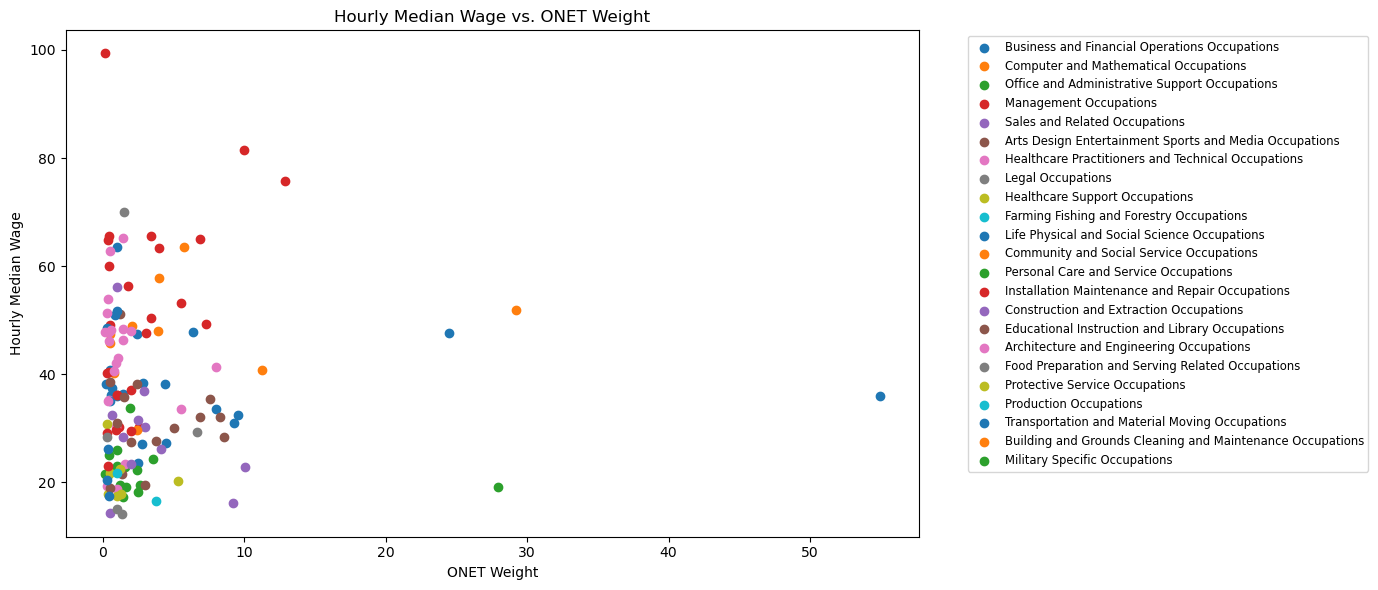

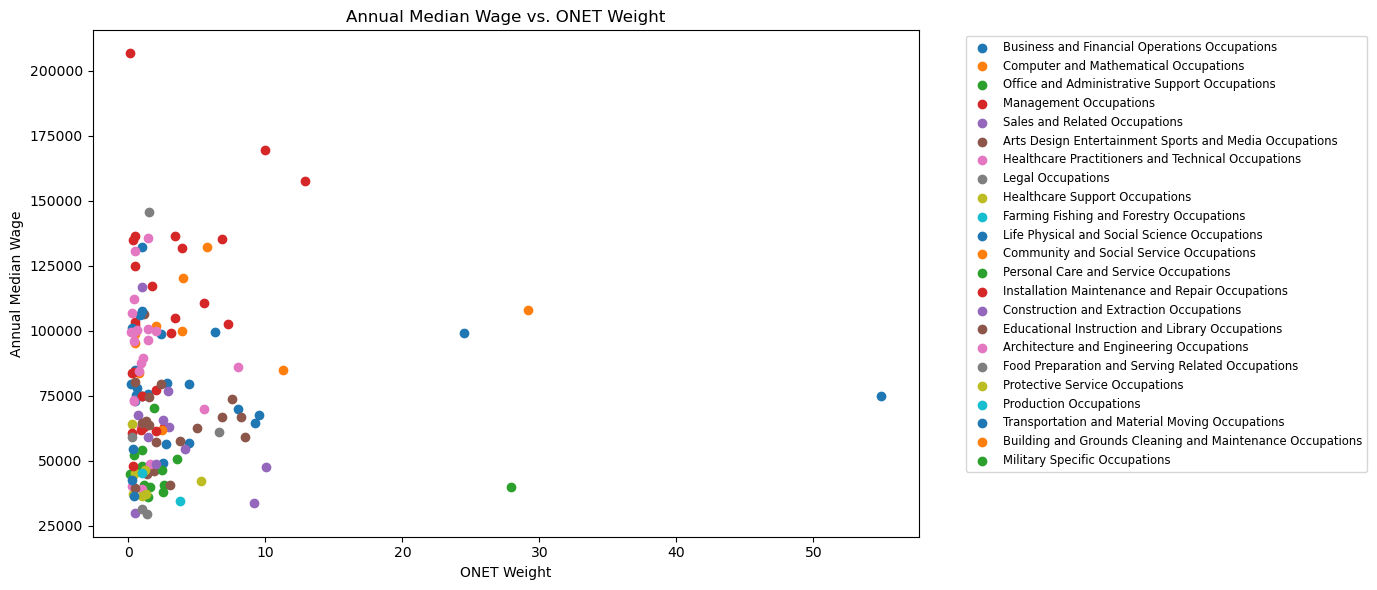

In [149]:
out = output()
out.getONET(task_sim=.67,title_sim=.7)
out.getWage()
out.getSkills()
# out.printExamples()
# out.generateOutput()
# out.writeExamples()

In [44]:
len(df["organization name"].unique())

510

In [ ]:
out.onet_weights

organization_name  onet_weight
0     AI Fashion Week     0.500000
1        AI Mavericks     1.000000
2           AI Square     0.166667
3               AIcon     1.000000
4            AIgeeked     0.333333
..                ...          ...
235           inPlace     0.500000
236       mimilabs.ai     0.333333
237            reprai     1.000000
238         stylio.ai     1.000000
239      tenXclinical     0.500000

[240 rows x 2 columns]

AREA AREA_TITLE  AREA_TYPE PRIM_STATE  NAICS     NAICS_TITLE  \
4       99       U.S.          1         US      0  Cross-industry   
6       99       U.S.          1         US      0  Cross-industry   
8       99       U.S.          1         US      0  Cross-industry   
11      99       U.S.          1         US      0  Cross-industry   
13      99       U.S.          1         US      0  Cross-industry   
...    ...        ...        ...        ...    ...             ...   
1395    99       U.S.          1         US      0  Cross-industry   
1396    99       U.S.          1         US      0  Cross-industry   
1398    99       U.S.          1         US      0  Cross-industry   
1400    99       U.S.          1         US      0  Cross-industry   
1402    99       U.S.          1         US      0  Cross-industry   

             I_GROUP  OWN_CODE OCC_CODE  \
4     cross-industry      1235  11-1011   
6     cross-industry      1235  11-1021   
8     cross-industry      1235  11-1031   
11    cross-industry      1235  11-2011   
13    cross-industry      1235  11-2021   
...              ...       ...      ...   
1395  cross-industry      1235  53-7072   
1396  cross-industry      1235  53-7073   
1398  cross-industry      1235  53-7081   
1400  cross-industry      1235  53-7121   
1402  cross-industry      1235  53-7199   

                                      OCC_TITLE  ... H_MEDIAN H_PCT75  \
4                              Chief Executives  ...    99.37       #   
6               General and Operations Managers  ...    48.69   77.06   
8                                   Legislators  ...        *       *   
11          Advertising and Promotions Managers  ...    63.40   90.64   
13                           Marketing Managers  ...    75.78  100.00   
...                                         ...  ...      ...     ...   
1395    Pump Operators, Except Wellhead Pumpers  ...    26.29   34.94   
1396                           Wellhead Pumpers  ...    34.53   38.98   
1398  Refuse and Recyclable Material Collectors  ...    22.00   28.06   
1400          Tank Car, Truck, and Ship Loaders  ...    28.18   34.96   
1402         Material Moving Workers, All Other  ...    19.38   23.30   

      H_PCT90  A_PCT10  A_PCT25  A_MEDIAN  A_PCT75  A_PCT90 ANNUAL  HOURLY  
4           #   80,000  130,840   206,680        #        #    NaN     NaN  
6      111.59   46,340   65,180   101,280  160,290  232,110    NaN     NaN  
8           *   21,010   28,810    47,290   82,200  129,510   True     NaN  
11          #   63,580   88,810   131,870  188,530        #    NaN     NaN  
13          #   79,600  108,000   157,620  208,000        #    NaN     NaN  
...       ...      ...      ...       ...      ...      ...    ...     ...  
1395    41.07   36,290   43,720    54,690   72,680   85,430    NaN     NaN  
1396    46.44   38,490   55,700    71,830   81,080   96,600    NaN     NaN  
1398    32.68   30,050   36,100    45,760   58,360   67,970    NaN     NaN  
1400    42.70   38,850   46,500    58,620   72,710   88,810    NaN     NaN  
1402    30.50   32,240   34,830    40,310   48,460   63,430    NaN     NaN  

[831 rows x 32 columns]

In [47]:
df = out.df
df

organization name founded date  \
0                                 Catio   2022-12-19   
1                                 Catio   2022-12-19   
2                                 Catio   2022-12-19   
3                             OpsBeacon   2023-02-01   
4                             OpsBeacon   2023-02-01   
...                                 ...          ...   
1810                     Lilac Voice AI   2024-03-01   
1811                     Lilac Voice AI   2024-03-01   
1812                     Lilac Voice AI   2024-03-01   
1813  POSI - Point Of Sale Intelligence   2024-05-01   
1814  POSI - Point Of Sale Intelligence   2024-05-01   

                                                website  \
0     San Francisco Bay Area, Silicon Valley, West C...   
1     San Francisco Bay Area, Silicon Valley, West C...   
2     San Francisco Bay Area, Silicon Valley, West C...   
3                                         opsbeacon.com   
4                                         opsbeacon.com   
...                                                 ...   
1810                                       lilaclabs.ai   
1811                                       lilaclabs.ai   
1812                                       lilaclabs.ai   
1813                                     www.posipay.io   
1814                                     www.posipay.io   

                                        description_all  \
0     Cloud architecture platform enabling companies...   
1     Cloud architecture platform enabling companies...   
2     Cloud architecture platform enabling companies...   
3     OpsBeacon is building a an AI Powered, No-Code...   
4     OpsBeacon is building a an AI Powered, No-Code...   
...                                                 ...   
1810  — Conversational AI Agent for Drive-Thru Order...   
1811  — Conversational AI Agent for Drive-Thru Order...   
1812  — Conversational AI Agent for Drive-Thru Order...   
1813  POSI is an AI powered point-of-sale system tha...   
1814  POSI is an AI powered point-of-sale system tha...   

                                      industries_parsed  \
0     ['Cloud Computing', 'Cloud Infrastructure', 'E...   
1     ['Cloud Computing', 'Cloud Infrastructure', 'E...   
2     ['Cloud Computing', 'Cloud Infrastructure', 'E...   
3     ['Apps', 'Cloud Computing', 'Data Integration'...   
4     ['Apps', 'Cloud Computing', 'Data Integration'...   
...                                                 ...   
1810   ['Enterprise Software', 'Generative AI', 'SaaS']   
1811   ['Enterprise Software', 'Generative AI', 'SaaS']   
1812   ['Enterprise Software', 'Generative AI', 'SaaS']   
1813                                                 []   
1814                                                 []   

                                  generated_description  \
0     Catio is a cloud architecture platform that he...   
1     Catio is a cloud architecture platform that he...   
2     Catio is a cloud architecture platform that he...   
3     OpsBeacon is a no-code, AI-powered platform th...   
4     OpsBeacon is a no-code, AI-powered platform th...   
...                                                 ...   
1810  Lilac Voice AI is a conversational AI agent de...   
1811  Lilac Voice AI is a conversational AI agent de...   
1812  Lilac Voice AI is a conversational AI agent de...   
1813  POSI is an AI-powered point-of-sale system tha...   
1814  POSI is an AI-powered point-of-sale system tha...   

                                     parsed_description  \
0     Cloud architecture design, Technology selectio...   
1     Cloud architecture design, Technology selectio...   
2     Cloud architecture design, Technology selectio...   
3     Workflow automation, Incident management, Syst...   
4     Workflow automation, Incident management, Syst...   
...                                                 ...   
1810  Order taking, Order processing, Speech recogni...   
1811  Order taking, Order processing, Spe

In [146]:

skills_df = pd.read_csv("../input/skills/Skills.csv")
skills_df = skills_df[skills_df["Scale Name"]=="Importance"]
skills_df = skills_df.rename(columns={"O*NET-SOC Code":"Detailed Occupation"})
skills_df["Detailed Occupation"] = skills_df["Detailed Occupation"].replace(r'\.\d{2}', '', regex=True)

In [144]:
skills_df

O*NET-SOC Code                              Title Element ID  \
0            11-1011                   Chief Executives    2.A.1.a   
2            11-1011                   Chief Executives    2.A.1.b   
4            11-1011                   Chief Executives    2.A.1.c   
6            11-1011                   Chief Executives    2.A.1.d   
8            11-1011                   Chief Executives    2.A.1.e   
...              ...                                ...        ...   
61100        53-7121  Tank Car, Truck, and Ship Loaders    2.B.4.h   
61102        53-7121  Tank Car, Truck, and Ship Loaders    2.B.5.a   
61104        53-7121  Tank Car, Truck, and Ship Loaders    2.B.5.b   
61106        53-7121  Tank Car, Truck, and Ship Loaders    2.B.5.c   
61108        53-7121  Tank Car, Truck, and Ship Loaders    2.B.5.d   

                            Element Name Scale ID  Scale Name  Data Value  \
0                  Reading Comprehension       IM  Importance        4.12   
2                       Active Listening       IM  Importance        4.00   
4                                Writing       IM  Importance        4.12   
6                               Speaking       IM  Importance        4.25   
8                            Mathematics       IM  Importance        3.25   
...                                  ...      ...         ...         ...   
61100                 Systems Evaluation       IM  Importance        2.12   
61102                    Time Management       IM  Importance        3.12   
61104  Management of Financial Resources       IM  Importance        2.00   
61106   Management of Material Resources       IM  Importance        2.00   
61108  Management of Personnel Resources       IM  Importance        2.88   

         N  Standard Error  Lower CI Bound  Upper CI Bound Recommend Suppress  \
0      8.0          0.1250          3.8800          4.3700                  N   
2      8.0          0.0000          4.0000          4.0000                  N   
4      8.0          0.1250          3.8800          4.3700                  N   
6      8.0          0.1637          3.9292          4.5708                  N   
8      8.0          0.2500          2.7600          3.7400                  N   
...    ...             ...             ...             ...                ...   
61100  8.0          0.1250          1.8800          2.3700                  N   
61102  8.0          0.1250          2.8800          3.3700                  N   
61104  8.0          0.0000          2.0000          2.0000                  N   
61106  8.0          0.0000          2.0000          2.0000                  N   
61108  8.0          0.1250          2.6300          3.1200                  N   

      Not Relevant     Date Domain Source  
0              NaN  08/2023       Analyst  
2              NaN  08/2023       Analyst  
4              NaN  08/2023       Analyst  
6              NaN  08/2023       Analyst  
8              NaN  08/2023       Analyst  
...            ...      ...           ...  
61100          NaN  08/2019       Analyst  
61102          NaN  08/2019       Analyst  
61104          NaN  08/2019       Analyst  
61106          NaN  08/2019       Analyst  
61108          NaN  08/2019       Analyst  

[30555 rows x 15 columns]

In [142]:
pivot_df = skills_df.pivot_table(index=skills_df["O*NET-SOC Code"], columns='Element Name', values='Data Value', fill_value=0)
print("\nPivoted DataFrame:")
pivot_df


Pivoted DataFrame:


Element Name    Active Learning  Active Listening  Complex Problem Solving  \
O*NET-SOC Code                                                               
11-1011                    3.75              4.00                     4.38   
11-1011.03                 3.75              4.00                     4.00   
11-1021                    3.62              4.00                     3.62   
11-2011                    3.25              4.12                     3.50   
11-2021                    3.88              3.88                     3.62   
...                         ...               ...                      ...   
53-7071                    2.88              3.12                     3.00   
53-7072                    2.88              3.12                     2.88   
53-7073                    2.38              2.88                     3.00   
53-7081                    2.25              2.88                     2.38   
53-7121                    2.75              3.00                     3.00   

Element Name    Coordination  Critical Thinking  Equipment Maintenance  \
O*NET-SOC Code                                                           
11-1011                 4.25               4.38                   1.00   
11-1011.03              3.75               4.12                   1.00   
11-1021                 3.88               3.88                   1.00   
11-2011                 3.50               4.00                   1.00   
11-2021                 3.50               3.88                   1.00   
...                      ...                ...                    ...   
53-7071                 3.00               3.62                   3.12   
53-7072                 2.88               3.12                   2.88   
53-7073                 2.25               3.12                   3.12   
53-7081                 2.62               2.75                   2.75   
53-7121                 2.88               3.00                   2.62   

Element Name    Equipment Selection  Installation  Instructing  \
O*NET-SOC Code                                                   
11-1011                        1.12          1.00         3.38   
11-1011.03                     1.12          1.00         3.25   
11-1021                        1.00          1.00         3.00   
11-2011                        1.12          1.00         2.88   
11-2021                        1.00          1.00         3.00   
...                             ...           ...          ...   
53-7071                        2.12          1.00         2.50   
53-7072                        2.25          1.12         2.88   
53-7073                        2.25          1.25         2.12   
53-7081                        1.75          1.00         1.88   
53-7121                        2.38          1.00         2.50   

Element Name    Judgment and Decision Making  ...  Science  \
O*NET-SOC Code                                ...            
11-1011                                 4.75  ...     1.62   
11-1011.03                              3.88  ...     2.12   
11-1021                                 3.62  ...     1.50   
11-2011                                 3.75  ...     1.62   
11-2021                                 3.75  ...     1.75   
...                                      ...  ...      ...   
53-7071                                 3.00  ...     1.88   
53-7072                                 3.00  ...     2.00   
53-7073                                 3.12  ...     1.12   
53-7081                                 2.38  ...     1.00   
53-7121                                 2.88  ...     1.50   

Element Name    Service Orientation  Social Perceptiveness  Speaking  \
O*NET-SOC Code                                                         
11-1011                        3.12                   4.12      4.25   
11-1011.03                     3.25                   3.88      4.00   
11-1021                        3.25                   3.75      4.00

In [151]:
wages_df = out.wages_df
skills_df = out.skills_df.reset_index()
bls_df = wages_df.merge(skills_df, on="Detailed Occupation")


In [152]:
bls_df = bls_df.replace(np.nan,0)

In [153]:
len(bls_df)

759

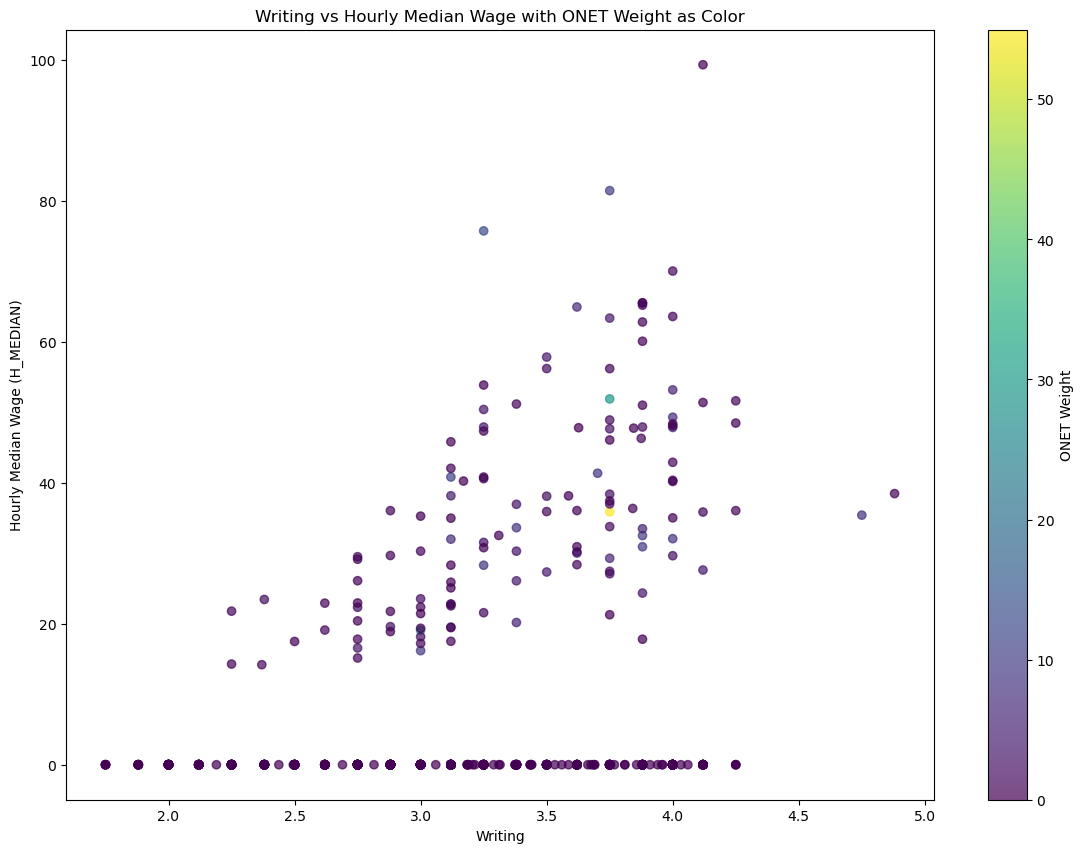

In [154]:
plt.figure(figsize=(14, 10))
scatter = plt.scatter(x=bls_df['Writing'], y=bls_df['H_MEDIAN'], c=bls_df['onet_weight'], cmap='viridis', alpha=0.7)
plt.xlabel('Writing')
plt.ylabel('Hourly Median Wage (H_MEDIAN)')
plt.title('Writing vs Hourly Median Wage with ONET Weight as Color')
plt.colorbar(scatter, label='ONET Weight')
plt.show()

In [155]:
bls_df

onet_title  onet_weight  \
0    Market Research Analysts and Marketing Special...        54.97   
1                                      Data Scientists        29.19   
2                     Customer Service Representatives        27.92   
3                                   Marketing Managers        12.90   
4                                       Web Developers        11.27   
..                                                 ...          ...   
754                                                  0         0.00   
755                                                  0         0.00   
756                                                  0         0.00   
757                                                  0         0.00   
758                                                  0         0.00   

    Detailed Occupation  AREA AREA_TITLE  AREA_TYPE PRIM_STATE  NAICS  \
0               13-1161  99.0       U.S.        1.0         US    0.0   
1               15-2051  99.0       U.S.        1.0         US    0.0   
2               43-4051  99.0       U.S.        1.0         US    0.0   
3               11-2021  99.0       U.S.        1.0         US    0.0   
4               15-1254  99.0       U.S.        1.0         US    0.0   
..                  ...   ...        ...        ...        ...    ...   
754             53-7071   0.0          0        0.0          0    0.0   
755             53-7072   0.0          0        0.0          0    0.0   
756             53-7073   0.0          0        0.0          0    0.0   
757             53-7081   0.0          0        0.0          0    0.0   
758             53-7121   0.0          0        0.0          0    0.0   

        NAICS_TITLE         I_GROUP  ...  Science Service Orientation  \
0    Cross-industry  cross-industry  ...    1.750               2.940   
1    Cross-industry  cross-industry  ...    2.065               2.815   
2    Cross-industry  cross-industry  ...    1.000               4.000   
3    Cross-industry  cross-industry  ...    1.750               3.120   
4    Cross-industry  cross-industry  ...    2.000               2.880   
..              ...             ...  ...      ...                 ...   
754               0               0  ...    1.880               2.250   
755               0               0  ...    2.000               2.380   
756               0               0  ...    1.120               1.880   
757               0               0  ...    1.000               2.380   
758               0               0  ...    1.500               2.250   

    Social Perceptiveness Speaking Systems Analysis  Systems Evaluation  \
0                    3.06     3.75            3.250               3.250   
1                    3.00     3.88            3.315               3.185   
2                    3.00     3.88            2.250               2.250   
3                    3.88     3.88            3.250               3.500   
4                    2.88     3.25            3.120               3.000   
..                    ...      ...              ...                 ...   
754                  2.75     3.00            2.620               2.000   
755                  2.75     3.12            2.380               2.120   
756                  2.50     3.00            2.000               2.000   
757                  2.50     2.88            1.380               1.380   
758                  2.62     3.00            2.500               2.120   

     Technology Design  Time Management  Troubleshooting  Writing  
0                2.000            3.060             1.06     3.75  
1                1.815            3.315             1.37     3.75  
2                1.880            3.120             1.00     3.00  
3                1.750            3.500             1.00     3.25  
4                2.500            3.000             2.12     3.12  
..                 ...              ...              ...      ...  
754              1.880            3.000             3.12    